<a href="https://colab.research.google.com/github/spexdj/Data_Science_II_Machine_Learning/blob/main/EntrenamientoyOptimizaci%C3%B3n_ProyectoFinal_Licastro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📊 Proyecto: Modelo Multivariado de Predicción de Ventas Totales

## 1. Abstracto: Motivación y Audiencia

En este análisis, buscamos responder en qué medida los descuentos ofrecidos en una tienda, junto con otras variables comerciales como la categoría del producto, el segmento del cliente o la prioridad del pedido, afectan el monto total de venta (`Sales.Total`). Este estudio será de utilidad para áreas de **marketing**, **finanzas** y **operaciones**, interesadas en entender los factores que más influyen en los ingresos y optimizar estrategias comerciales sin sacrificar rentabilidad.

---

## 2. Formulación del problema como ML

**Problema principal:**  
¿Cuánto influyen los descuentos y otras variables clave sobre el monto de venta total?

**Tipo de problema:**  
Regresión supervisada (predictiva)

**Variable objetivo:** `Sales.Total`  
**Variables explicativas:**  
- `Discount`  
- `Quantity`  
- `Year`  
- `Order_Priority`  
- `Segment`  
- `Category`  
- `Sub.Category`  
- Combinación: `Discount x Quantity`


In [15]:
# 1. Importación de librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [16]:
# 2. Carga de datos
url = "https://raw.githubusercontent.com/spexdj/Data_Science_II_Machine_Learning/refs/heads/main/superstore3.csv"
df = pd.read_csv(url, encoding='latin1', on_bad_lines='skip')

In [17]:
# 3. Renombrar columnas con espacios o caracteres especiales
df.rename(columns={
    "Order Priority": "Order.Priority",
    "Sub-Category": "Sub.Category"
}, inplace=True)

In [18]:
# 4. Conversión de columnas numéricas que vienen como texto
df["Discount"] = df["Discount"].astype(str).str.replace("%", "").astype(float) / 100
df["Sales.Total"] = df["Sales.Total"].astype(str).str.replace("$", "").str.replace(",", "").astype(float)

In [19]:
# 5. Verificación de inconsistencias y valores extremos
print("Valores con descuento mayor al 100%:")
print(df[df["Discount"] > 1])

print("\nVentas totales atípicas:")
print(df[df["Sales.Total"] > df["Sales.Total"].quantile(0.99)])

Valores con descuento mayor al 100%:
Empty DataFrame
Columns: [Customer.ID, Customer.Name, Category, City, Country, Discount, Market, Order.Date, Order.Time, Order.ID, Order.Priority, Product.ID, Product.Name, Sales.Price, Quantity, Region, ItemsSale.Count, Sales.Total, Segment, Ship.Date, Ship_Time, Ship.Mode, Shipping.Cost, State, Sub.Category, Year]
Index: []

[0 rows x 26 columns]

Ventas totales atípicas:
      Customer.ID       Customer.Name         Category           City  \
503     JK-152054        Jamie Kunitz  Office Supplies  San Francisco   
803     RW-195404         Rick Wilson  Office Supplies      Brentwood   
1137    JD-161504    Justin Deggeller  Office Supplies  New York City   
1146    DJ-136304         Doug Jacobs  Office Supplies  New York City   
1742    YC-218954      Yoseph Carroll  Office Supplies         Newark   
...           ...                 ...              ...            ...   
50987   IM-150554       Ionia McGrath       Technology  San Francisco   
51

In [21]:
# 6. Selección de variables relevantes para el análisis
variables = ["Discount", "Quantity", "Year", "Order.Priority", "Segment", "Category", "Sub.Category", "Sales.Total"]
df_model = df[variables].dropna()

In [22]:
# 7. Feature engineering: crear variable combinada entre descuento y cantidad
df_model["Discount_x_Quantity"] = df_model["Discount"] * df_model["Quantity"]

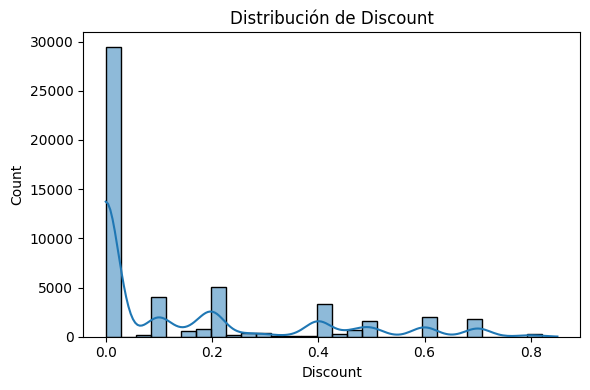

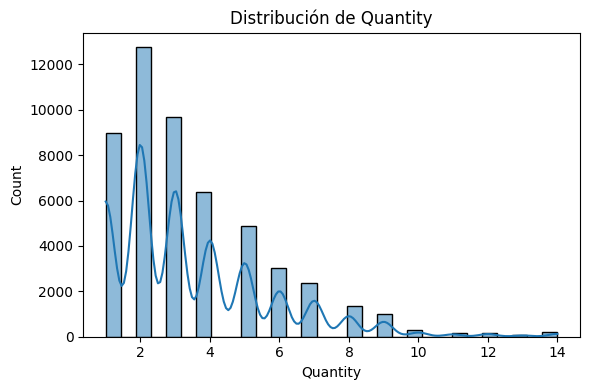

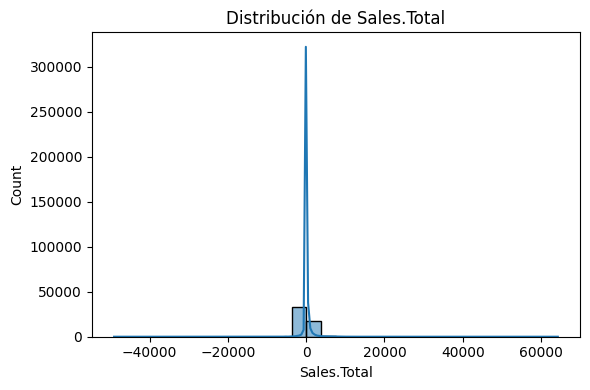

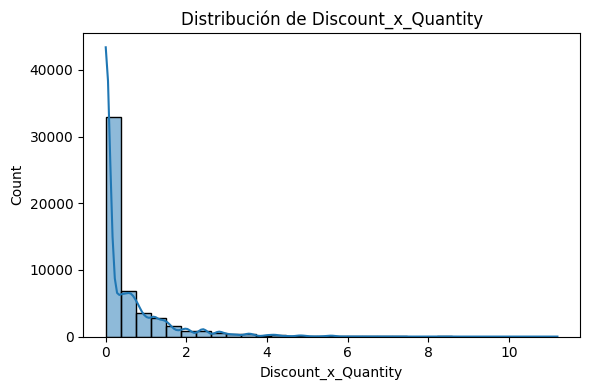

In [23]:
# 8. Análisis exploratorio univariado
num_vars = ["Discount", "Quantity", "Sales.Total", "Discount_x_Quantity"]

for var in num_vars:
    plt.figure(figsize=(6, 4))
    sns.histplot(df_model[var], bins=30, kde=True)
    plt.title(f"Distribución de {var}")
    plt.tight_layout()
    plt.show()

#📊 Distribuciones numéricas (histogramas + KDE)
Discount:
- La mayoría de los descuentos aplicados son cercanos a 0, lo que indica que en la mayoría de las órdenes no se aplica descuento o es muy bajo.
- Hay picos en valores específicos como 0.1, 0.2, etc., lo que sugiere que se aplican rangos fijos de descuentos preestablecidos.
- Se observa una fuerte asimetría hacia la izquierda, típica en promociones aplicadas solo en ciertos productos o eventos.

Quantity:
- La cantidad de unidades por orden sigue una distribución sesgada hacia la izquierda, siendo lo más común comprar entre 1 y 4 unidades.
- Hay un patrón discreto (enteros), como es lógico para variables de cantidad.
- A partir de 10 unidades la frecuencia disminuye significativamente.

Sales.Total:
- Las ventas totales tienen una distribución fuertemente asimétrica, con presencia de valores negativos (probablemente devoluciones o errores).
- El grueso de las ventas está concentrado cerca de 0, lo que podría estar indicando ventas de bajo valor.
- Existen algunos valores extremadamente altos, posiblemente outliers.

Discount x Quantity
- Esta variable combinada permite visualizar la interacción entre descuento y volumen.
- La mayoría de los valores se concentran cerca de 0, reflejando pedidos pequeños con poco o ningún descuento.
- Su distribución también es asimétrica, con una larga cola derecha (grandes pedidos con alto descuento).


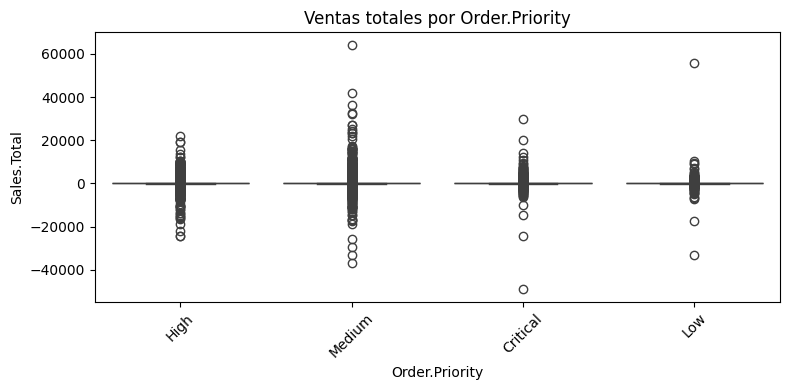

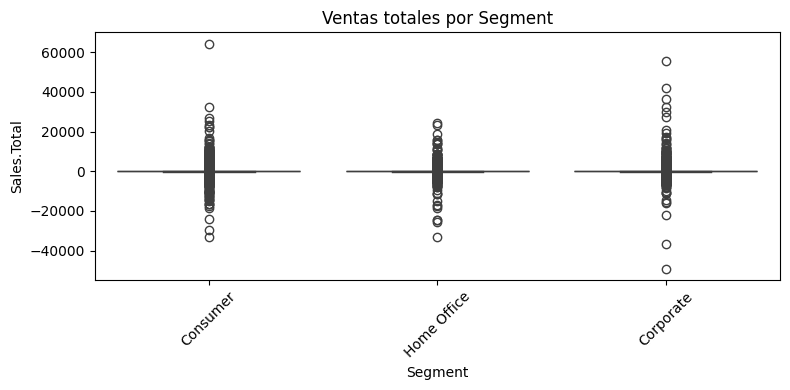

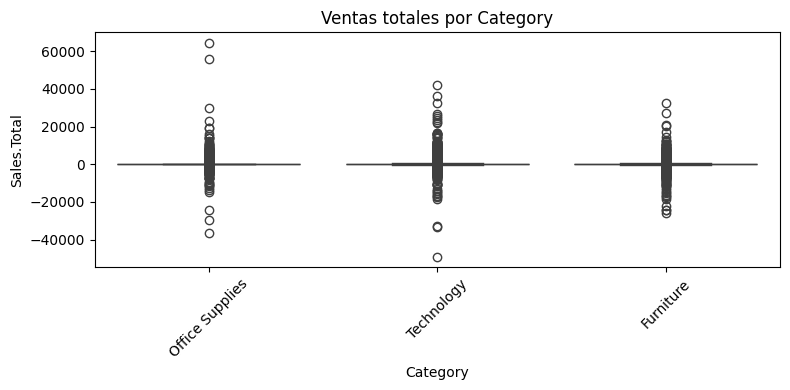

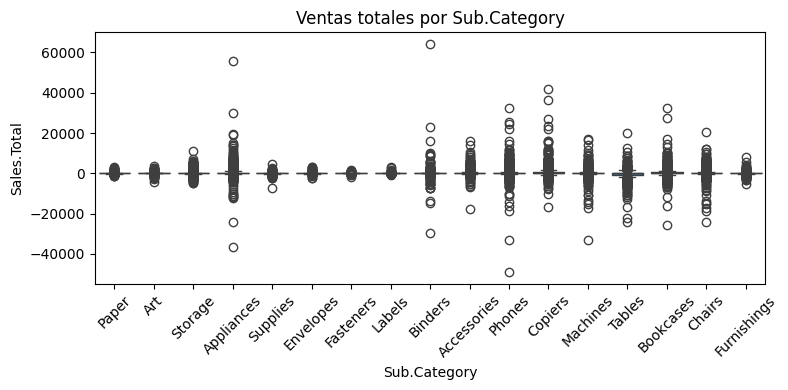

In [25]:
# 9. Análisis de variables categóricas vs ventas (boxplots)
cat_vars = ["Order.Priority", "Segment", "Category", "Sub.Category"]

for var in cat_vars:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df_model, x=var, y="Sales.Total")
    plt.title(f"Ventas totales por {var}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#📦 Distribución de ventas por categorías (boxplots)

Order.Priority:
- No se observan diferencias significativas en la mediana de ventas entre prioridades de pedido.
- Las distribuciones son similares, con alta cantidad de outliers en todos los casos.
- Esto podría indicar que la prioridad de pedido no tiene una relación directa con el monto de ventas.

Segment:
- Los tres segmentos presentan una distribución similar en ventas, pero "Corporate" muestra una leve mayor dispersión.
- Se evidencian muchos valores extremos tanto positivos como negativos.
- Puede no ser un diferenciador tan fuerte en términos de ventas, pero aporta información contextual.

Category:
- La categoría "Technology" muestra mayor variabilidad en las ventas, posiblemente asociada a productos de alto valor.
- "Office Supplies" y "Furniture" tienen menor dispersión y más valores negativos.

Sub.Category:
- Se observa gran cantidad de subcategorías con comportamiento muy disperso.
- Algunas como "Copiers" o "Phones" tienen valores mucho más altos que el resto, indicando productos de alto valor.
- Esta granularidad es útil para segmentar estrategias de pricing o promociones.



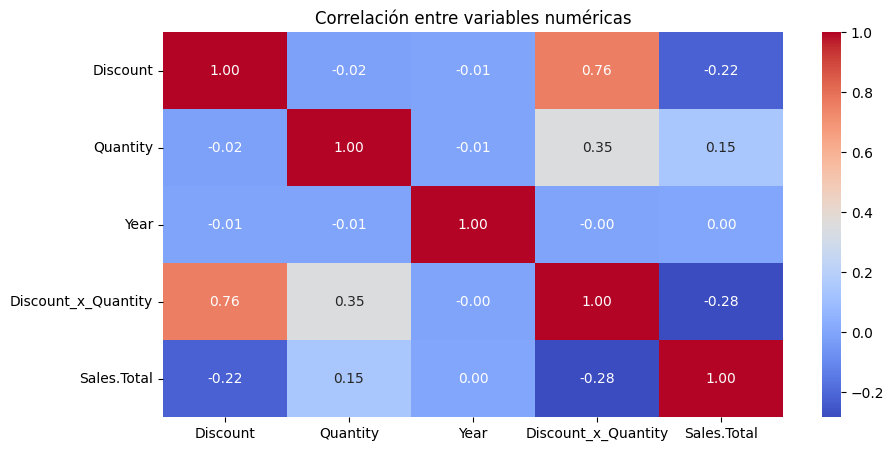

In [26]:
# 10. Heatmap de correlación entre variables numéricas
plt.figure(figsize=(10, 5))
sns.heatmap(df_model[["Discount", "Quantity", "Year", "Discount_x_Quantity", "Sales.Total"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlación entre variables numéricas")
plt.show()

#🔥 Correlación entre variables numéricas (Heatmap)
- `Discount` y `Discount_x_Quantity` están altamente correlacionadas (r=0.76), como se esperaba por construcción.
- `Sales.Total` muestra correlaciones negativas con `Discount` y `Discount_x_Quantity`, lo que podría indicar que mayores descuentos no necesariamente implican mayores ingresos.
- `Quantity` tiene leve correlación positiva con las ventas, lo que sugiere que el volumen tiene algo más de peso.



In [27]:
# 11. División de datos para entrenamiento
X = df_model.drop("Sales.Total", axis=1)
y = df_model["Sales.Total"]

In [32]:
# 12. Definición de variables numéricas y categóricas
numeric_features = ["Discount", "Quantity", "Year", "Discount_x_Quantity"]
categorical_features = ["Order.Priority", "Segment", "Category", "Sub.Category"]

In [33]:
# 13. Preprocesador combinado: escalar + codificar
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])


In [34]:
# 14. Modelos a evaluar
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}


=== Random Forest ===
R²: 0.0808
RMSE: 1097.19
MAE: 291.32
R² promedio CV (5-fold): -0.1656


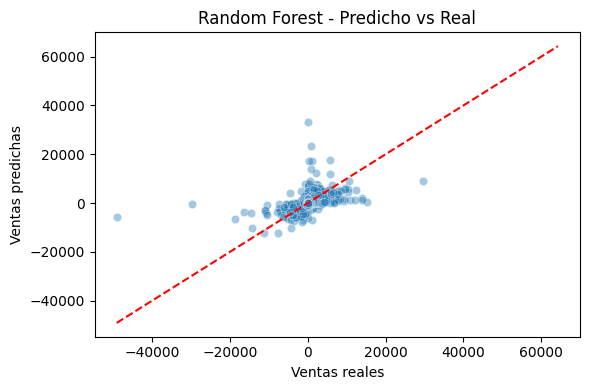


=== Gradient Boosting ===
R²: 0.3036
RMSE: 955.00
MAE: 277.99
R² promedio CV (5-fold): 0.1960


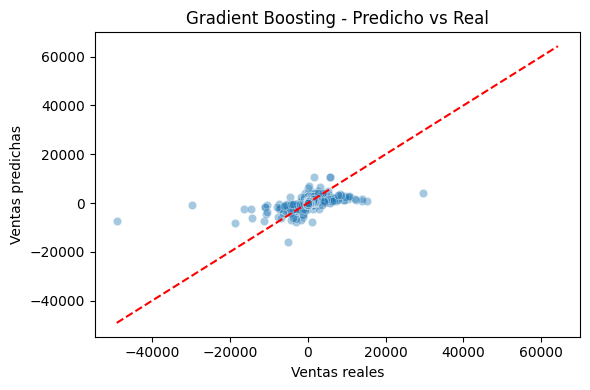

In [35]:
# 15. Evaluación de modelos con split y cross-validation
for name, model in models.items():
    print(f"\n=== {name} ===")

    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", model)
    ])

    # División de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Entrenamiento
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Métricas con hold-out
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    print(f"R²: {r2:.4f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")

    # Cross-validation
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')
    print(f"R² promedio CV (5-fold): {scores.mean():.4f}")

    # Gráfico de predicciones
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
    plt.title(f"{name} - Predicho vs Real")
    plt.xlabel("Ventas reales")
    plt.ylabel("Ventas predichas")
    plt.tight_layout()
    plt.show()

#📈 Predicción vs Real - Modelos

Random Forest:
- El modelo presenta un bajo desempeño predictivo (R² ≈ 0.08), indicando que no está capturando bien la variabilidad de los datos.
- El RMSE y MAE son altos en relación a la escala de ventas.
- El gráfico muestra alta concentración en valores bajos, con algunas predicciones fuera de rango.

Gradient Boosting:
- Mejora notable respecto a Random Forest, con R² ≈ 0.30.
- También mejora en RMSE y MAE, mostrando un ajuste más razonable.
- Aunque sigue existiendo concentración alrededor de los valores bajos, se nota mejor alineación con la diagonal esperada.




In [36]:
# 16. Optimización con GridSearchCV para Random Forest
param_grid = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth': [5, 10, None]
}

rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(random_state=42))
])

grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

print("\n🔧 Mejores parámetros Random Forest:")
print(grid_search.best_params_)
print("RMSE CV (GridSearch):", -grid_search.best_score_)


🔧 Mejores parámetros Random Forest:
{'regressor__max_depth': 10, 'regressor__n_estimators': 50}
RMSE CV (GridSearch): 1007.3005848391364


## 17. Conclusiones
- La variable `Discount` presenta una correlación negativa con `Sales.Total` (-0.22), lo que sugiere que mayores descuentos no necesariamente incrementan las ventas. Esto se confirma también en la combinación `Discount x Quantity`, que muestra una correlación aún más negativa (-0.28) con las ventas.
- El análisis de boxplots por categoría, segmento y prioridad no revela diferencias sustanciales en los montos de ventas, pero sí deja ver una fuerte presencia de outliers, lo que indica una alta variabilidad en los valores de ventas sin un patrón categórico claro.
- Los histogramas mostraron una distribución altamente sesgada en la mayoría de las variables, especialmente `Sales.Total`, con valores extremos tanto negativos como positivos, lo cual afecta la predicción.
- El modelo de **Random Forest** tuvo un desempeño bajo (R² ≈ 0.08 y RMSE ≈ 1097), mientras que **Gradient Boosting** logró mejorar los resultados significativamente (R² ≈ 0.30 y RMSE ≈ 955).
- En términos generales, **los modelos de regresión utilizados no alcanzan un nivel de precisión alto**, lo cual puede deberse a la alta dispersión, presencia de valores extremos, y posiblemente a variables relevantes no incluidas en el modelo.
